In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import visdom

import mxnet as mx
from mxnet import gluon
from mxnet import autograd
from mxnet import image

import sys
sys.path.append('../../resuneta/src')
sys.path.append('../../decode/FracTAL_ResUNet/models/semanticsegmentation')
sys.path.append('../../decode/FracTAL_ResUNet/nn/loss')
sys.path.append('../../')
sys.path.append('../MXNet-ResUNeta/')

from bound_dist import get_distance, get_boundary
from FracTAL_ResUNet import FracTAL_ResUNet_cmtsk
from ftnmt_loss import ftnmt_loss_masked
from datasets import *

from sklearn.metrics import matthews_corrcoef

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def dice_coef(x, y):
    if type(x).__module__ == 'numpy':
        intersection = np.logical_and(x, y)
        return 2. * np.sum(intersection) / (np.sum(x) + np.sum(y))
    else:
        intersection = mx.ndarray.op.broadcast_logical_and(x, y)
        return 2. * mx.nd.sum(intersection) / (mx.nd.sum(x) + mx.nd.sum(y))

In [3]:
def visdom_visualize_batch(vis, img, extent, boundary, distance,
                           extent_pred, boundary_pred, distance_pred,
                           hsv, hsv_pred, mask, title="Train images"):

    img, extent, boundary, distance = img.asnumpy(), extent.asnumpy(), boundary.asnumpy(), distance.asnumpy()
    extent_pred, boundary_pred = extent_pred.asnumpy(), boundary_pred.asnumpy()
    distance_pred, hsv, hsv_pred = distance_pred.asnumpy(), hsv.asnumpy(), hsv_pred.asnumpy()
    mask = mask.asnumpy()

    # put everything in one window
    batch_size, nchannels, nrows, ncols = img.shape
    padding = 10
    items = [img, hsv, hsv_pred, extent, extent_pred, 
             boundary, boundary_pred, distance, distance_pred,
             mask]
    result = np.zeros((3, len(items)*nrows + (len(items)-1)*padding, batch_size*ncols + (batch_size-1)*padding))

    for j, item in enumerate(items):

        if item.shape[1] == 1:
            item = np.tile(item, (1,3,1,1)) * 255.

        if j == 1 or j == 2: # convert HSV to RGB
            item = np.moveaxis(item, 1, -1) * 255.
            for i in range(batch_size):
                item[i] = cv2.cvtColor(item[i].astype(np.uint8), cv2.COLOR_HSV2RGB)
            item = np.moveaxis(item, -1, 1)
            
        for i in range(batch_size):
            result[:, j*(nrows+padding):(j+1)*nrows+j*padding, i*(ncols+padding):(i+1)*ncols+i*padding] = item[i]
    vis.images(result, nrow=1, win=title, opts={'title': title})


In [4]:
def train_model(train_dataloader, model, tanimoto_dual, trainer, epoch, args):
    
    # initialize metrics
    cumulative_loss = 0
    accuracy = mx.metric.Accuracy()
    f1 = mx.metric.F1()
    mcc = mx.metric.MCC()
    dice = mx.metric.CustomMetric(feval=dice_coef, name="Dice")
    if args['ctx_name'] == 'cpu':
        ctx = mx.cpu()
    else:
        ctx = mx.gpu(args['gpu'])
    
    # training set
    for batch_i, (img, extent, boundary, distance, hsv, mask) in enumerate(
        tqdm(train_dataloader, desc='Training epoch {}'.format(epoch))):
        
        with autograd.record():

            img = img.as_in_context(ctx)
            extent = extent.as_in_context(ctx)
            boundary = boundary.as_in_context(ctx)
            distance = distance.as_in_context(ctx)
            hsv = hsv.as_in_context(ctx)
            mask = mask.as_in_context(ctx)
            nonmask = mx.nd.ones(extent.shape).as_in_context(ctx)
            
            # logits, bound, dist, convc = model(img)
            logits, bound, dist = model(img)
            
            # multi-task loss
            # TODO: wrap this in a custom loss function / class
            loss_extent = mx.nd.sum(tanimoto_dual(logits, extent, mask))
            loss_boundary = mx.nd.sum(tanimoto_dual(bound, boundary, mask))
            loss_distance = mx.nd.sum(tanimoto_dual(dist, distance, mask))

            loss = 0.33 * (loss_extent + loss_boundary + loss_distance) # + loss_hsv)
            
        loss.backward()
        trainer.step(args['batch_size'])
        cumulative_loss += mx.nd.sum(loss).asscalar()
        
        logits_reshaped = logits.reshape((logits.shape[0], -1))
        extent_reshaped = extent.reshape((extent.shape[0], -1))
        mask_reshaped = mask.reshape((mask.shape[0], -1))
        
        nonmask_idx = mx.np.nonzero(mask_reshaped.as_np_ndarray())
        nonmask_idx = mx.np.stack(nonmask_idx).as_nd_ndarray().as_in_context(ctx)
        logits_masked = mx.nd.gather_nd(logits_reshaped, nonmask_idx)
        extent_masked = mx.nd.gather_nd(extent_reshaped, nonmask_idx)

        # accuracy
        extent_predicted_classes = mx.nd.ceil(logits_masked - 0.5)
        accuracy.update(extent_masked, extent_predicted_classes)
        
        # f1 score
        probabilities = mx.nd.stack(1 - logits_masked, logits_masked, axis=1)
        f1.update(extent_masked, probabilities)
        
        # MCC metric
        mcc.update(extent_masked, probabilities)
        
        # Dice score
        dice.update(extent_masked, extent_predicted_classes)
        
        # TEMPORARY to make visdom work
        convc = hsv
        if batch_i % args['visdom_every'] == 0:
            visdom_visualize_batch(args['visdom'], img, extent, boundary, distance,
                                   logits, bound, dist, hsv, convc, mask)

    return cumulative_loss, accuracy, f1, mcc, dice

In [5]:
def evaluate_model(val_dataloader, model, tanimoto_dual, epoch, args):
    
    # initialize metrics
    cumulative_loss = 0
    accuracy = mx.metric.Accuracy()
    f1 = mx.metric.F1()
    mcc = mx.metric.MCC()
    dice = mx.metric.CustomMetric(feval=dice_coef, name="Dice")
    if args['ctx_name'] == 'cpu':
        ctx = mx.cpu()
    else:
        ctx = mx.gpu(args['gpu'])
    
    # validation set
    for batch_i, (img, extent, boundary, distance, hsv, mask) in enumerate(
        tqdm(val_dataloader, desc='Validation epoch {}'.format(epoch))):

        img = img.as_in_context(ctx)
        extent = extent.as_in_context(ctx)
        boundary = boundary.as_in_context(ctx)
        distance = distance.as_in_context(ctx)
        hsv = hsv.as_in_context(ctx)
        mask = mask.as_in_context(ctx)
        nonmask = mx.nd.ones(extent.shape).as_in_context(ctx)

        # logits, bound, dist, convc = model(img)
        logits, bound, dist = model(img)
        
        # multi-task loss
        # TODO: wrap this in a custom loss function / class
        loss_extent = mx.nd.sum(tanimoto_dual(logits, extent, mask))
        loss_boundary = mx.nd.sum(tanimoto_dual(bound, boundary, mask))
        loss_distance = mx.nd.sum(tanimoto_dual(dist, distance, mask))

        loss = 0.33 * (loss_extent + loss_boundary + loss_distance) # + loss_hsv)
        
        # update metrics based on every batch
        cumulative_loss += mx.nd.sum(loss).asscalar()
        
        # update metrics based on every batch
        # mask out unlabeled pixels            
        logits_reshaped = logits.reshape((logits.shape[0], -1))
        extent_reshaped = extent.reshape((extent.shape[0], -1))
        mask_reshaped = mask.reshape((mask.shape[0], -1))
        
        nonmask_idx = mx.np.nonzero(mask_reshaped.as_np_ndarray())
        nonmask_idx = mx.np.stack(nonmask_idx).as_nd_ndarray().as_in_context(ctx)
        logits_masked = mx.nd.gather_nd(logits_reshaped, nonmask_idx)
        extent_masked = mx.nd.gather_nd(extent_reshaped, nonmask_idx)

        # accuracy
        extent_predicted_classes = mx.nd.ceil(logits_masked - 0.5)
        accuracy.update(extent_masked, extent_predicted_classes)
        
        # f1 score
        probabilities = mx.nd.stack(1 - logits_masked, logits_masked, axis=1)
        f1.update(extent_masked, probabilities)
        
        # MCC metric
        mcc.update(extent_masked, probabilities)
        
        # Dice score
        dice.update(extent_masked, extent_predicted_classes)
        
        # TEMPORARY to make visdom work
        convc = hsv
        if batch_i % args['visdom_every'] == 0:
            visdom_visualize_batch(args['visdom'], img, extent, boundary, distance,
                                   logits, bound, dist, hsv, convc, mask, title="Val images")
        
    return cumulative_loss, accuracy, f1, mcc, dice

# Africa datasets

In [6]:
def run_africa(country, train_names, val_names, test_names, 
               train_names_label, val_names_label, test_names_label,
               trained_model=None,
               epochs=100, lr=0.001, lr_decay=None, 
               model_type='resunet-d6',
               n_filters=16, batch_size=8,
               depth=5, n_classes=1, 
               month='janFebMar',
               codes_to_keep=[1, 2],
               folder_suffix='',
               boundary_kernel_size=3,
               ctx_name='cpu',
               gpu_id=0):
    
    # Set MXNet ctx
    if ctx_name == 'cpu':
        ctx = mx.cpu()
    elif ctx_name == 'gpu':
        ctx = mx.gpu(gpu_id)
    
    # Set up names of directories and paths for saving
    if trained_model is None:
        folder_name = model_type+'_'+month+'_nfilter-'+str(n_filters)+ \
                      '_depth-'+str(depth)+'_bs-'+str(batch_size)+'_lr-'+str(lr)+folder_suffix
        if lr_decay:
            folder_name = folder_name + '_lrdecay-'+str(lr_decay)
            
        # define model
        if model_type == 'resunet-d6':
            model = ResUNet_d6(_nfilters_init=n_filters, _NClasses=n_classes)
        elif model_type == 'resunet-d7':
            model = ResUNet_d7(_nfilters_init=n_filters, _NClasses=n_classes)
        elif model_type == 'fractal-resunet':
            model = FracTAL_ResUNet_cmtsk(nfilters_init=n_filters, depth=depth, NClasses=n_classes)
        model.initialize()
        model.hybridize()
        model.collect_params().reset_ctx(ctx)
        
    else:
        folder_name = model_type+'_'+month+'_nfilter-'+str(n_filters)+ \
                      '_bs-'+str(batch_size)+'_lr-'+str(lr)+folder_suffix+'_finetuned'
        if model_type == 'resunet-d6':
            model = ResUNet_d6(_nfilters_init=n_filters, _NClasses=n_classes)
        elif model_type == 'resunet-d7':
            model = ResUNet_d7(_nfilters_init=n_filters, _NClasses=n_classes)
        model.load_parameters(trained_model, ctx=ctx)
        
    save_path = os.path.join('../experiments/', country, folder_name)
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    save_model_name = os.path.join(save_path, "model.params")
    
    # Visdom
    env_name = country + '_' + folder_name
    vis = visdom.Visdom(port=8097, env=env_name)
    
    # Arguments
    args = {}
    args['batch_size'] = batch_size
    args['ctx_name'] = ctx_name
    args['gpu'] = gpu_id
    args['visdom'] = vis
    args['visdom_every'] = 20

    # Define train/val/test splits
    train_dataset = PlanetDatasetWithClassesFullPathsMasked(
        fold='train', 
        image_names=train_names, 
        label_names=train_names_label, 
        classes=codes_to_keep,
        boundary_kernel_size=boundary_kernel_size)
    val_dataset = PlanetDatasetWithClassesFullPathsMasked(
        fold='val', 
        image_names=val_names, 
        label_names=val_names_label, 
        classes=codes_to_keep,
        boundary_kernel_size=boundary_kernel_size)
    test_dataset = PlanetDatasetWithClassesFullPathsMasked(
        fold='test', 
        image_names=test_names, 
        label_names=test_names_label, 
        classes=codes_to_keep,
        boundary_kernel_size=boundary_kernel_size)

    train_dataloader = gluon.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = gluon.data.DataLoader(val_dataset, batch_size=batch_size)
    test_dataloader = gluon.data.DataLoader(test_dataset, batch_size=batch_size)

    # define loss function
    tanimoto_dual = ftnmt_loss_masked(depth=0) # Tanimoto_with_dual_masked()
    if lr_decay:
        schedule = mx.lr_scheduler.FactorScheduler(step=1, factor=lr_decay)
        adam_optimizer = mx.optimizer.Adam(learning_rate=lr, lr_scheduler=schedule)
    else:
        adam_optimizer = mx.optimizer.Adam(learning_rate=lr)
    trainer = gluon.Trainer(model.collect_params(), optimizer=adam_optimizer)

    # containers for metrics to log
    train_metrics = {'train_loss': [], 'train_acc': [], 'train_f1': [], 
                     'train_mcc': [], 'train_dice': []}
    val_metrics = {'val_loss': [], 'val_acc': [], 'val_f1': [], 
                   'val_mcc': [], 'val_dice': []}
    best_mcc = 0.0

    # training loop
    for epoch in range(1, epochs+1):

        # training set
        train_loss, train_accuracy, train_f1, train_mcc, train_dice = train_model(
            train_dataloader, model, tanimoto_dual, trainer, epoch, args)

        # training set metrics
        train_loss_avg = train_loss / len(train_dataset)
        train_metrics['train_loss'].append(train_loss_avg)
        train_metrics['train_acc'].append(train_accuracy.get()[1])
        train_metrics['train_f1'].append(train_f1.get()[1])
        train_metrics['train_mcc'].append(train_mcc.get()[1])
        train_metrics['train_dice'].append(train_dice.get()[1])

        # validation set
        val_loss, val_accuracy, val_f1, val_mcc, val_dice = evaluate_model(
            val_dataloader, model, tanimoto_dual, epoch, args)

        # validation set metrics
        val_loss_avg = val_loss / len(val_dataset)
        val_metrics['val_loss'].append(val_loss_avg)
        val_metrics['val_acc'].append(val_accuracy.get()[1])
        val_metrics['val_f1'].append(val_f1.get()[1])
        val_metrics['val_mcc'].append(val_mcc.get()[1])
        val_metrics['val_dice'].append(val_dice.get()[1])

        print("Epoch {}:".format(epoch))
        print("    Train loss {:0.3f}, accuracy {:0.3f}, F1-score {:0.3f}, MCC: {:0.3f}, Dice: {:0.3f}".format(
            train_loss_avg, train_accuracy.get()[1], train_f1.get()[1], train_mcc.get()[1], train_dice.get()[1]))
        print("    Val loss {:0.3f}, accuracy {:0.3f}, F1-score {:0.3f}, MCC: {:0.3f}, Dice: {:0.3f}".format(
            val_loss_avg, val_accuracy.get()[1], val_f1.get()[1], val_mcc.get()[1], val_dice.get()[1]))

        # save model based on best MCC metric
        if val_mcc.get()[1] > best_mcc:
            model.save_parameters(save_model_name)
            best_mcc = val_mcc.get()[1]

        # save metrics
        metrics = pd.concat([pd.DataFrame(train_metrics), pd.DataFrame(val_metrics)], axis=1)
        metrics.to_csv(os.path.join(save_path, 'metrics.csv'), index=False)

        # visdom
        vis.line(Y=np.stack([train_metrics['train_loss'], val_metrics['val_loss']], axis=1), 
                 X=np.arange(1, epoch+1), win="Loss", 
                 opts=dict(legend=['train loss', 'val loss'], markers=False, title="Losses",
                           xlabel="Epoch", ylabel="Loss")
                )
        vis.line(Y=np.stack([train_metrics['train_mcc'], val_metrics['val_mcc']], axis=1), 
                 X=np.arange(1, epoch+1), win="MCC", 
                 opts=dict(legend=['train MCC', 'val MCC'], markers=False, title="MCC",
                           xlabel="Epoch", ylabel="MCC")
                )


In [ ]:
# ============================ #
# user-specified hyperparameters
# ============================ #
country = 'partial-france'
epochs = 100
lr = 0.001
lr_decay = None
n_filters = 32
depth = 6
n_classes = 1
batch_size = 8
model_type = 'fractal-resunet' # 'resunet-d6'
month_name = '3month-separate'
codes_to_keep = list(range(1,10)) + [11,14,15,16,17,18,19,21,24,25,26,28]
ctx_name = 'gpu'
gpu_id = 2
boundary_kernel_size = (2,2)

# trained_model = '../experiments/france/sherrie10k/' + \
#     'resunet-d6_2019_10_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001_1x-8x-downsampled/model.params'
trained_model = None
splits_path = '../data/splits/sherrie10k_planetImagery_splits_20x20_4x-downsampled.csv'
splits_df = pd.read_csv(splits_path)
splits_df['image_id'] = splits_df['image_id'].astype(str).str.zfill(5)

# get all img and labels
all_img_names = []
all_label_names = []
img_dir = '../data/planet/france/sherrie10k/monthly_mosaics_renamed_clipped_merged/1250px/'
label_dir = '../data/planet/france/sherrie10k/extent_labels/1250px/'
subfolders = ['2x_downsample', '3x_downsample']

for subfolder in subfolders:
    label_folder_imgs = sorted(os.listdir(os.path.join(label_dir, subfolder)))
    for month in ['2019_04', '2019_07', '2019_10']:
        for label_name in label_folder_imgs:
            img_name = label_name.split('.')[0] + '_' + month + '.tif'
            img_path = os.path.join(img_dir, subfolder, month, img_name)
            all_img_names.append(img_path)
            label_path = os.path.join(label_dir, subfolder, label_name)
            all_label_names.append(label_path)

# split imgs and labels into train/val/test
all_images = pd.DataFrame({'img_path': all_img_names})
all_images['image_id'] = all_images['img_path'].str.split('/').apply(
    lambda x: x[-1]).str.split('.').apply(
    lambda x: x[0]).str.split('_').apply(
    lambda x: x[0])
all_images = all_images.merge(splits_df[['image_id', 'fold']], on='image_id', how='left')
train_names = all_images[all_images['fold'] == 'train']['img_path'].values
val_names = all_images[all_images['fold'] == 'val']['img_path'].values
test_names = all_images[all_images['fold'] == 'test']['img_path'].values

all_labels = pd.DataFrame({'label_path': all_label_names})
all_labels['image_id'] = all_labels['label_path'].str.split('/').apply(
    lambda x: x[-1]).str.split('.').apply(
    lambda x: x[0])
all_labels = all_labels.merge(splits_df[['image_id', 'fold']], on='image_id', how='left')
train_names_label = all_labels[all_labels['fold'] == 'train']['label_path'].values
val_names_label = all_labels[all_labels['fold'] == 'val']['label_path'].values
test_names_label = all_labels[all_labels['fold'] == 'test']['label_path'].values

# ============================ #

run_africa(country, train_names, val_names, test_names,
           train_names_label, val_names_label, test_names_label,
           trained_model=trained_model,
           epochs=epochs, lr=lr, lr_decay=lr_decay, 
           model_type=model_type, n_filters=n_filters, depth=depth, n_classes=n_classes,
           batch_size=batch_size, month=month_name,
           codes_to_keep=codes_to_keep, 
           ctx_name=ctx_name,
           gpu_id=gpu_id, 
           folder_suffix='_2x-3x-downsampled_allfields_n6759',
           boundary_kernel_size=boundary_kernel_size)

depth:= 0, nfilters: 32, nheads::8, widths::1
depth:= 1, nfilters: 64, nheads::16, widths::1
depth:= 2, nfilters: 128, nheads::32, widths::1
depth:= 3, nfilters: 256, nheads::64, widths::1
depth:= 4, nfilters: 512, nheads::128, widths::1
depth:= 5, nfilters: 1024, nheads::256, widths::1
depth:= 6, nfilters: 512, nheads::256, widths::1
depth:= 7, nfilters: 256, nheads::128, widths::1
depth:= 8, nfilters: 128, nheads::64, widths::1
depth:= 9, nfilters: 64, nheads::32, widths::1
depth:= 10, nfilters: 32, nheads::16, widths::1


Setting up a new session...
Validation epoch 1:  17%|█▋        | 196/1160 [01:45<06:18,  2.55it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training epoch 2:  68%|██████▊   | 3452/5067 [49:22<23:14,  1.16it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Validation epoch 3: 100%|██████████| 1160/1160 [08:50<00:00,  2.19it/s]


Epoch 3:
    Train loss 0.253, accuracy 0.856, F1-score 0.910, MCC: 0.534, Dice: 0.910
    Val loss 0.230, accuracy 0.869, F1-score 0.919, MCC: 0.541, Dice: 0.919


Training epoch 4:   1%|▏         | 75/5067 [01:07<1:03:07,  1.32it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training epoch 5:  94%|█████████▎| 4743/5067 [52:59<04:14,  1.27it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training epoch 7:   0%|          | 0/5067 [00:00<?, ?it/s]

Epoch 6:
    Train loss 0.243, accuracy 0.863, F1-score 0.914, MCC: 0.556, Dice: 0.914
    Val loss 0.223, accuracy 0.878, F1-score 0.926, MCC: 0.552, Dice: 0.926


Training epoch 7:  86%|████████▌ | 4360/5067 [48:38<06:58,  1.69it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training epoch 8:  81%|████████  | 4097/5067 [48:39<10:27,  1.55it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training epoch 10:   0%|          | 0/5067 [00:00<?, ?it/s]

Epoch 9:
    Train loss 0.238, accuracy 0.867, F1-score 0.917, MCC: 0.566, Dice: 0.917
    Val loss 0.223, accuracy 0.880, F1-score 0.926, MCC: 0.555, Dice: 0.926


Training epoch 11:   0%|          | 0/5067 [00:00<?, ?it/s]

Epoch 10:
    Train loss 0.237, accuracy 0.868, F1-score 0.917, MCC: 0.569, Dice: 0.917
    Val loss 0.221, accuracy 0.878, F1-score 0.925, MCC: 0.558, Dice: 0.925


Training epoch 12:   0%|          | 0/5067 [00:00<?, ?it/s]

Epoch 11:
    Train loss 0.236, accuracy 0.868, F1-score 0.918, MCC: 0.571, Dice: 0.918
    Val loss 0.222, accuracy 0.873, F1-score 0.921, MCC: 0.558, Dice: 0.921


Training epoch 13:   0%|          | 0/5067 [00:00<?, ?it/s]

Epoch 12:
    Train loss 0.235, accuracy 0.869, F1-score 0.918, MCC: 0.573, Dice: 0.918
    Val loss 0.224, accuracy 0.880, F1-score 0.927, MCC: 0.547, Dice: 0.927


Training epoch 14:   0%|          | 0/5067 [00:00<?, ?it/s]

Epoch 13:
    Train loss 0.234, accuracy 0.870, F1-score 0.918, MCC: 0.575, Dice: 0.918
    Val loss 0.223, accuracy 0.877, F1-score 0.925, MCC: 0.548, Dice: 0.925


Training epoch 15:   0%|          | 0/5067 [00:00<?, ?it/s]

Epoch 14:
    Train loss 0.233, accuracy 0.870, F1-score 0.919, MCC: 0.576, Dice: 0.919
    Val loss 0.224, accuracy 0.879, F1-score 0.926, MCC: 0.546, Dice: 0.926


Training epoch 16:   0%|          | 0/5067 [00:00<?, ?it/s]

Epoch 15:
    Train loss 0.232, accuracy 0.871, F1-score 0.919, MCC: 0.578, Dice: 0.919
    Val loss 0.225, accuracy 0.877, F1-score 0.925, MCC: 0.548, Dice: 0.925


Training epoch 17:   0%|          | 0/5067 [00:00<?, ?it/s]

Epoch 16:
    Train loss 0.231, accuracy 0.871, F1-score 0.919, MCC: 0.579, Dice: 0.919
    Val loss 0.233, accuracy 0.876, F1-score 0.926, MCC: 0.514, Dice: 0.926


Training epoch 18:   0%|          | 0/5067 [00:00<?, ?it/s]

Epoch 17:
    Train loss 0.230, accuracy 0.872, F1-score 0.920, MCC: 0.580, Dice: 0.920
    Val loss 0.228, accuracy 0.875, F1-score 0.924, MCC: 0.522, Dice: 0.924


Training epoch 19:   0%|          | 0/5067 [00:00<?, ?it/s]

Epoch 18:
    Train loss 0.230, accuracy 0.872, F1-score 0.920, MCC: 0.582, Dice: 0.920
    Val loss 0.230, accuracy 0.875, F1-score 0.925, MCC: 0.518, Dice: 0.925


Training epoch 20:   0%|          | 0/5067 [00:00<?, ?it/s]

Epoch 19:
    Train loss 0.229, accuracy 0.872, F1-score 0.920, MCC: 0.582, Dice: 0.920
    Val loss 0.235, accuracy 0.875, F1-score 0.925, MCC: 0.506, Dice: 0.925


Training epoch 21:   0%|          | 0/5067 [00:00<?, ?it/s]

Epoch 20:
    Train loss 0.229, accuracy 0.873, F1-score 0.920, MCC: 0.583, Dice: 0.920
    Val loss 0.239, accuracy 0.874, F1-score 0.925, MCC: 0.488, Dice: 0.925


Training epoch 21:  97%|█████████▋| 4929/5067 [1:15:44<01:49,  1.27it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training epoch 22:  63%|██████▎   | 3200/5067 [49:14<25:35,  1.22it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Training epoch 23:  51%|█████     | 2577/5067 [35:57<27:34,  1.51it/s]  

In [ ]:
month = '2019_10'
image_dir = '../data/planet/france/sherrie10k/monthly_mosaics_renamed_clipped_merged/1250px/2x-3x_downsample/' + month
label_dir = '../data/planet/france/sherrie10k/extent_labels/1250px/2x-3x_downsample/'

# image_ids = [str(x).zfill(5) for x in range(10000)]
image_ids = sorted([x.split('.')[0] for x in os.listdir(label_dir)])
for image_id in image_ids:
    if not os.path.exists(os.path.join(image_dir, image_id + '_' + month + '.tif')):
        print(image_id, " does not exist")

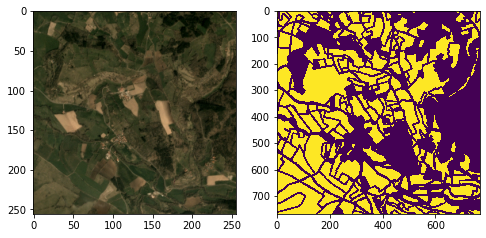

In [13]:
image_dir = '../data/planet/france/sherrie10k/monthly_mosaics_renamed_clipped_merged/1250px/3x_downsample/2019_04/'
label_dir = '../data/planet/france/sherrie10k/extent_labels/1250px/3x_downsample/'
image_id = '00000'

img = imageio.imread(os.path.join(image_dir, image_id + '_2019_04.tif'))
label = imageio.imread(os.path.join(label_dir, image_id + '.png')) > 0
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img)
ax[1].imshow(label[:256*3,:256*3], interpolation='nearest')
plt.show()

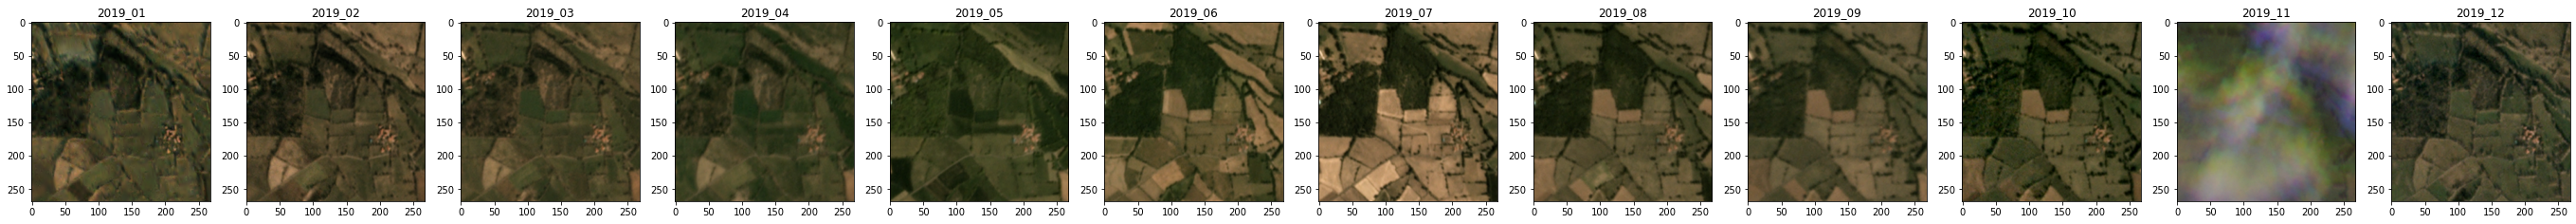

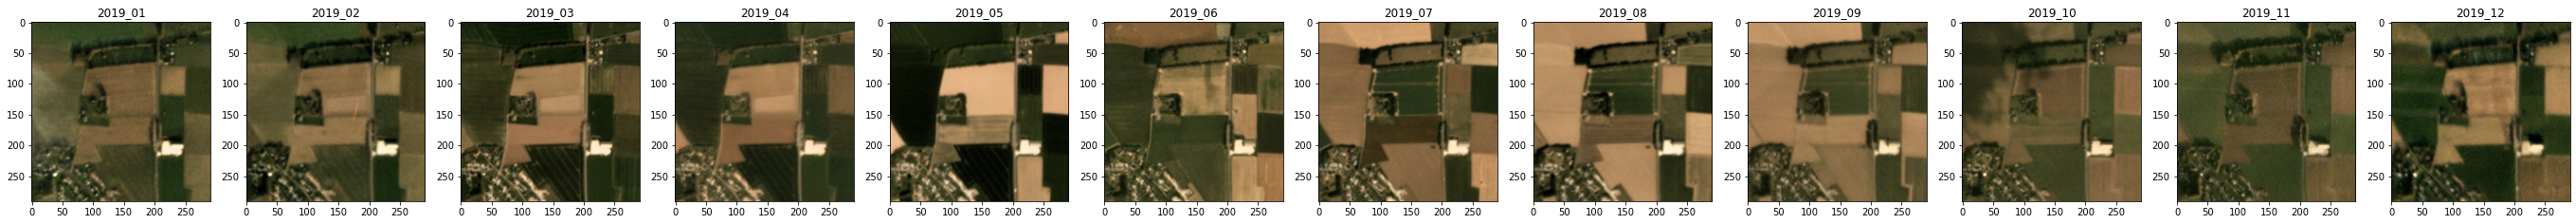

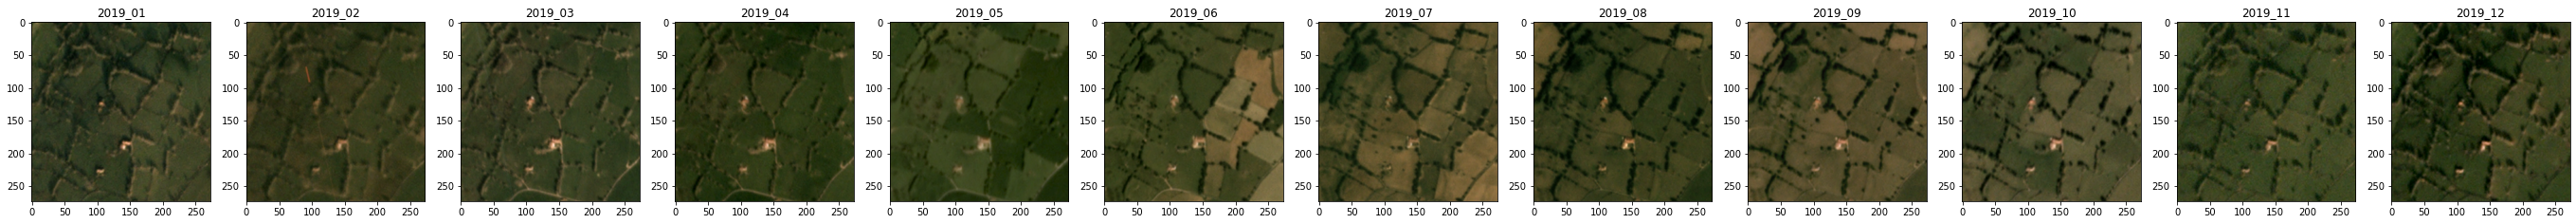

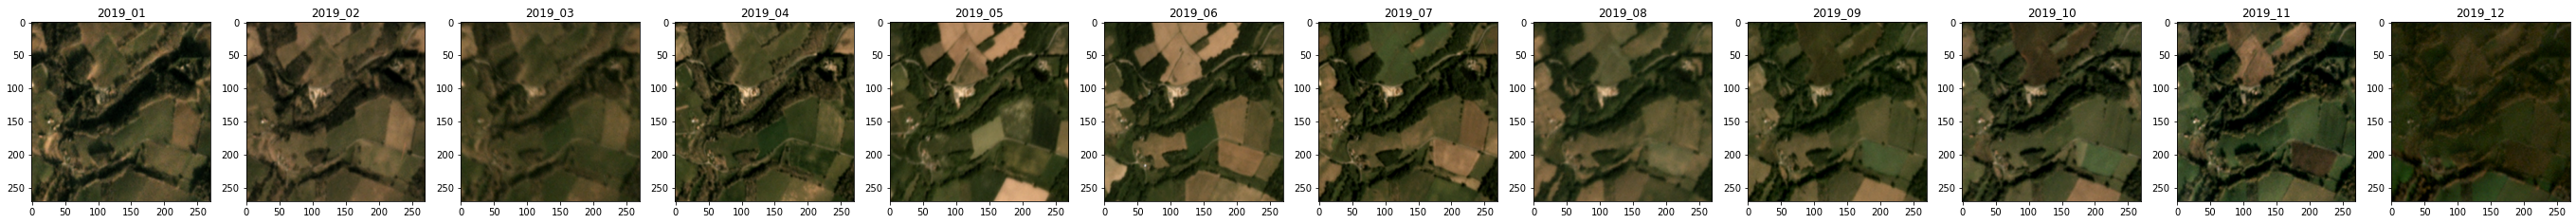

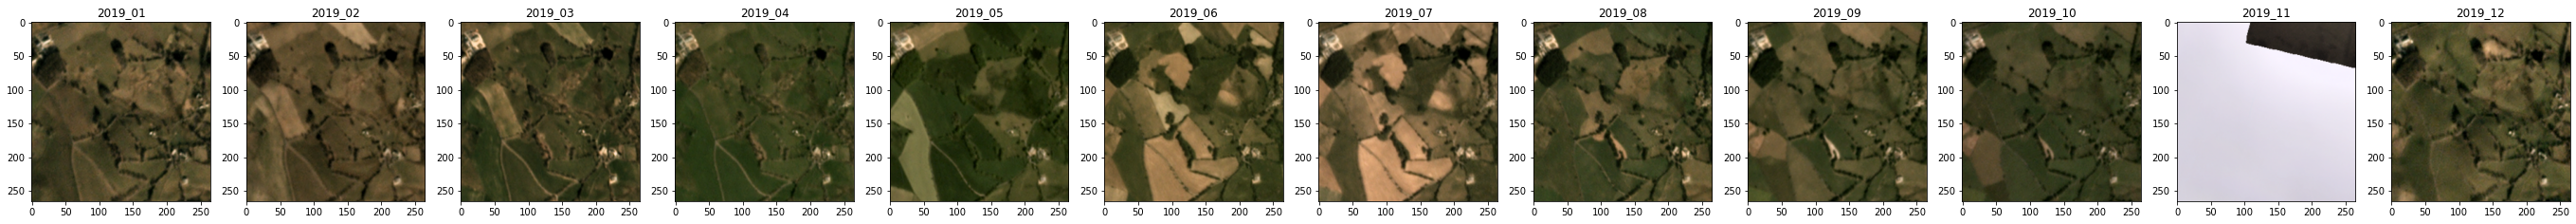

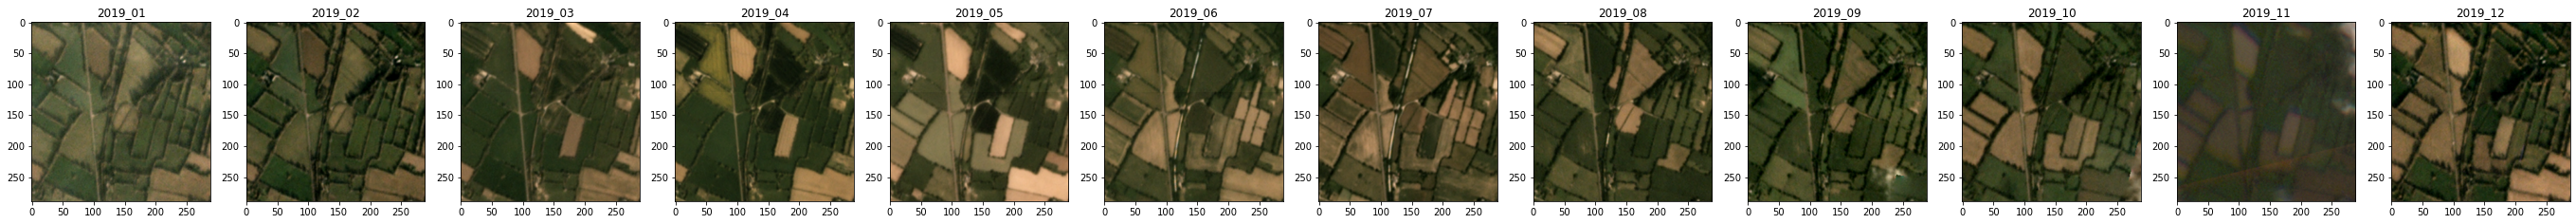

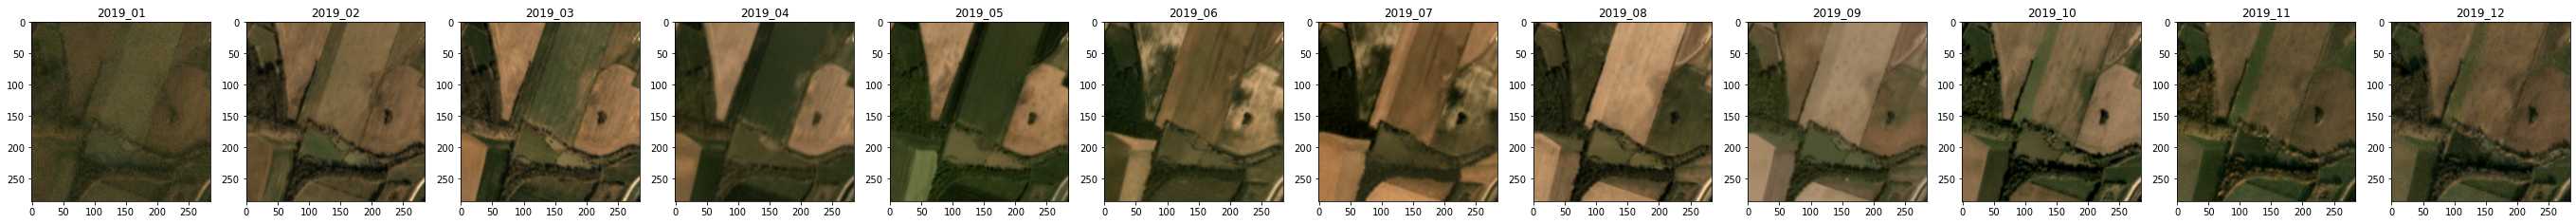

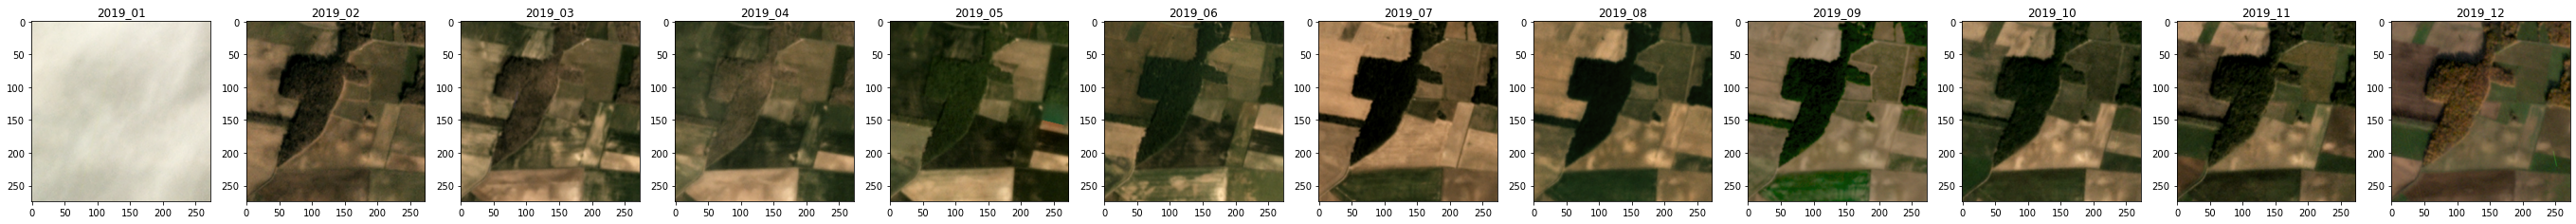

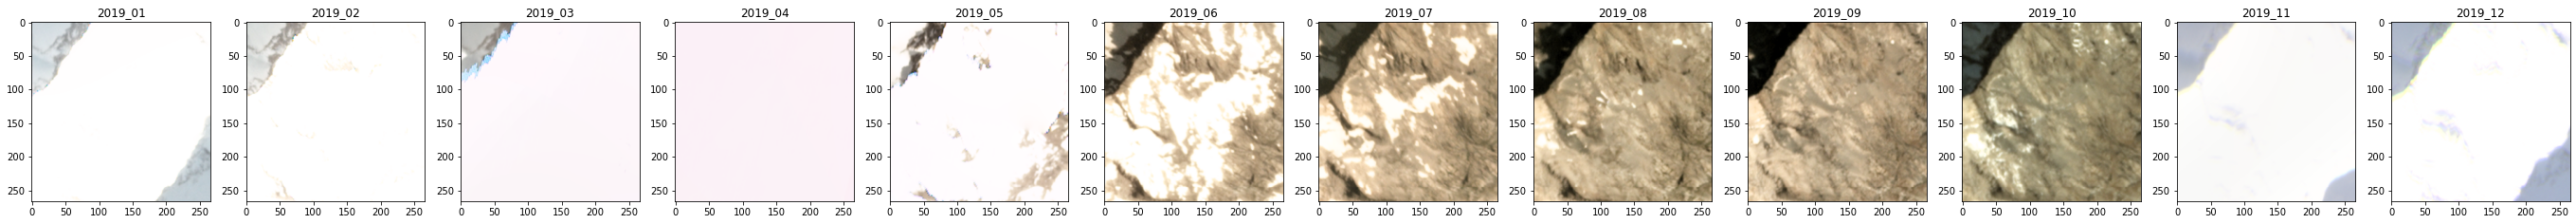

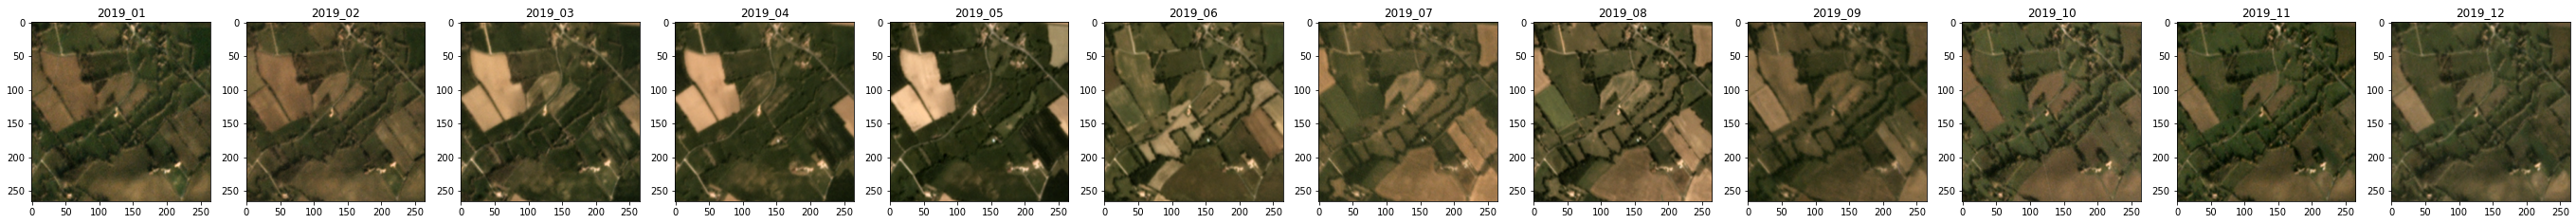

In [10]:
img_dir = '../data/planet/france/sherrie10k/monthly_mosaics_renamed_clipped_merged/300px/'
months = ['2019_{}'.format(str(x).zfill(2)) for x in range(1, 13)]
image_ids = ['{}'.format(str(x).zfill(5)) for x in range(10)]

for image_id in image_ids:
    fig, ax = plt.subplots(1, 12, figsize=(4*len(months), 4))
    for i, month in enumerate(months):
        ax[i].imshow(imageio.imread(os.path.join(img_dir, month, '{}_{}.tif'.format(image_id, month))))
        ax[i].set_title(month)
    plt.show()